In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#get train and test data, resize to 32x32 to fit LeNet (originally 28x28)
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))])
)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))])
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
#define dataloaders 
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = training_data,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                           batch_size = batch_size,
                                           shuffle = True)

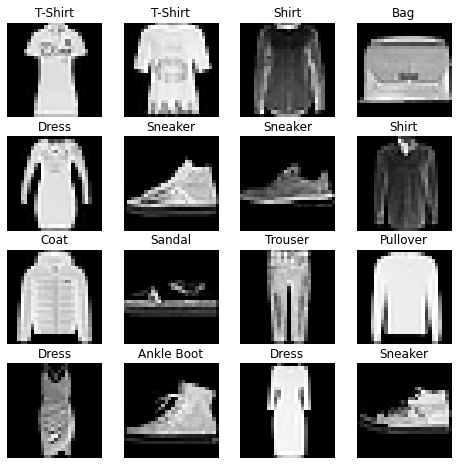

In [4]:
#Visualize the dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, 17):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
#build LeNet5 class with batch normalization
class LeNet5_bn(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv1bn = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv1bn = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
#Build LeNet5 dropout model
class LeNet5_dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # add dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
#Build LeNet5 model with no changes
class LeNet5(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
#define a function that receives a model and optimizer and trains one epoch + returns accuracy
def train_one_epoch(model,optimizer,epoch,loss):
  model.train()
  total_loss = 0
  avg_loss = 0
  accuracy = 0
  nof_samples = 0
  correct_labeled_samples = 0
  for batch_idx, (inputs,labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    #forward pass and loss
    outputs = model(inputs)
    loss = cost(outputs,labels)
    

    #backprop & zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    correct_labeled_samples += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    nof_samples += len(inputs)
    accuracy = correct_labeled_samples / nof_samples
    avg_loss = total_loss / (batch_idx + 1)
    if (batch_idx+1) % 400 == 0:
      print(f'Loss: {avg_loss:.3f} | '
            f'Acc: {accuracy:.2f}[%] '
            f'({correct_labeled_samples}/{nof_samples})')
  return accuracy

In [16]:
#define a function that evaluates trained model on test data and returns accuracy
def evaluate_model(model,optimizer,epoch,loss):
  model.eval()
  total_loss = 0
  avg_loss = 0
  accuracy = nof_samples = 0
  correct_labeled_samples = 0
  for batch_idx, (inputs,labels) in enumerate(test_loader):
    with torch.no_grad():
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = cost(outputs,labels)
      total_loss += loss.item()
      correct_labeled_samples += (outputs.argmax(1) == labels).type(torch.float).sum().item()
      nof_samples += len(inputs)
      accuracy = correct_labeled_samples / nof_samples
      avg_loss = total_loss / (batch_idx + 1)
      if (batch_idx+1) % 400 == 0:
        print(f'Loss: {avg_loss:.3f} | '
              f'Acc: {accuracy:.2f}[%] '
              f'({correct_labeled_samples}/{nof_samples})')
  return accuracy


In [17]:
#define a function that trains, evaluates, and logs all results for plotting 
def main(epochs,model,optimizer,model_name,loss):
  output_data = {"model": model_name,
                 "train_acc": [],
                 "test_acc":[],
                 }
  for epoch in range(1, epochs + 1):
            print(f'Epoch {epoch}/{epochs}')

            train_acc = train_one_epoch(model,optimizer,epochs,loss)
            test_acc = evaluate_model(model,optimizer,epochs,loss)
            output_data["train_acc"].append(train_acc)
            output_data["test_acc"].append(test_acc)
            filename = model_name + '.json'
            with open(filename, 'w', encoding='utf-8') as f:
              json.dump(output_data, f, indent=4)


In [18]:
#run main on regular model
#Define the first model
model1 = LeNet5().to(device) #the fashion mnist dataset has 10 classes-> 10 possible labels

#Define the loss function
cost = nn.CrossEntropyLoss()

#Define the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

main(10,model1,optimizer,'Regular_Model',cost)

Epoch 1/10
Loss: 0.773 | Acc: 0.71[%] (18295.0/25600)
Loss: 0.638 | Acc: 0.76[%] (39004.0/51200)
Epoch 2/10
Loss: 0.410 | Acc: 0.85[%] (21802.0/25600)
Loss: 0.393 | Acc: 0.86[%] (43866.0/51200)
Epoch 3/10
Loss: 0.337 | Acc: 0.88[%] (22451.0/25600)
Loss: 0.337 | Acc: 0.88[%] (44865.0/51200)
Epoch 4/10
Loss: 0.309 | Acc: 0.89[%] (22690.0/25600)
Loss: 0.309 | Acc: 0.89[%] (45392.0/51200)
Epoch 5/10
Loss: 0.292 | Acc: 0.89[%] (22805.0/25600)
Loss: 0.290 | Acc: 0.89[%] (45680.0/51200)
Epoch 6/10
Loss: 0.278 | Acc: 0.90[%] (22964.0/25600)
Loss: 0.275 | Acc: 0.90[%] (45997.0/51200)
Epoch 7/10
Loss: 0.261 | Acc: 0.90[%] (23153.0/25600)
Loss: 0.259 | Acc: 0.90[%] (46322.0/51200)
Epoch 8/10
Loss: 0.247 | Acc: 0.91[%] (23245.0/25600)
Loss: 0.248 | Acc: 0.91[%] (46470.0/51200)
Epoch 9/10
Loss: 0.236 | Acc: 0.91[%] (23338.0/25600)
Loss: 0.241 | Acc: 0.91[%] (46604.0/51200)
Epoch 10/10
Loss: 0.218 | Acc: 0.92[%] (23540.0/25600)
Loss: 0.226 | Acc: 0.92[%] (46882.0/51200)


In [19]:
#define model with dropout
model_dropout = LeNet5_dropout().to(device)
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=0.001)
main(10,model_dropout,optimizer,'Dropout_Model',cost)

Epoch 1/10
Loss: 0.928 | Acc: 0.65[%] (16535.0/25600)
Loss: 0.773 | Acc: 0.70[%] (36089.0/51200)
Epoch 2/10
Loss: 0.532 | Acc: 0.80[%] (20539.0/25600)
Loss: 0.516 | Acc: 0.81[%] (41496.0/51200)
Epoch 3/10
Loss: 0.448 | Acc: 0.83[%] (21331.0/25600)
Loss: 0.441 | Acc: 0.84[%] (42882.0/51200)
Epoch 4/10
Loss: 0.407 | Acc: 0.85[%] (21810.0/25600)
Loss: 0.401 | Acc: 0.85[%] (43711.0/51200)
Epoch 5/10
Loss: 0.378 | Acc: 0.86[%] (21990.0/25600)
Loss: 0.378 | Acc: 0.86[%] (44078.0/51200)
Epoch 6/10
Loss: 0.357 | Acc: 0.87[%] (22233.0/25600)
Loss: 0.363 | Acc: 0.87[%] (44350.0/51200)
Epoch 7/10
Loss: 0.345 | Acc: 0.87[%] (22327.0/25600)
Loss: 0.347 | Acc: 0.87[%] (44635.0/51200)
Epoch 8/10
Loss: 0.334 | Acc: 0.87[%] (22374.0/25600)
Loss: 0.335 | Acc: 0.87[%] (44781.0/51200)
Epoch 9/10
Loss: 0.332 | Acc: 0.88[%] (22462.0/25600)
Loss: 0.329 | Acc: 0.88[%] (44989.0/51200)
Epoch 10/10
Loss: 0.322 | Acc: 0.88[%] (22532.0/25600)
Loss: 0.320 | Acc: 0.88[%] (45096.0/51200)


In [20]:
#define model with batch-norm
model_bn = LeNet5_bn().to(device)
optimizer = torch.optim.Adam(model_bn.parameters(), lr=0.001)
main(10,model_bn,optimizer,'BN_Model',cost)

Epoch 1/10
Loss: 0.768 | Acc: 0.71[%] (18231.0/25600)
Loss: 0.633 | Acc: 0.76[%] (39088.0/51200)
Epoch 2/10
Loss: 0.409 | Acc: 0.85[%] (21807.0/25600)
Loss: 0.395 | Acc: 0.86[%] (43833.0/51200)
Epoch 3/10
Loss: 0.340 | Acc: 0.87[%] (22366.0/25600)
Loss: 0.338 | Acc: 0.88[%] (44819.0/51200)
Epoch 4/10
Loss: 0.310 | Acc: 0.89[%] (22669.0/25600)
Loss: 0.310 | Acc: 0.89[%] (45343.0/51200)
Epoch 5/10
Loss: 0.291 | Acc: 0.89[%] (22820.0/25600)
Loss: 0.287 | Acc: 0.89[%] (45729.0/51200)
Epoch 6/10
Loss: 0.267 | Acc: 0.90[%] (23032.0/25600)
Loss: 0.267 | Acc: 0.90[%] (46076.0/51200)
Epoch 7/10
Loss: 0.257 | Acc: 0.90[%] (23109.0/25600)
Loss: 0.257 | Acc: 0.90[%] (46269.0/51200)
Epoch 8/10
Loss: 0.243 | Acc: 0.91[%] (23267.0/25600)
Loss: 0.242 | Acc: 0.91[%] (46595.0/51200)
Epoch 9/10
Loss: 0.226 | Acc: 0.92[%] (23459.0/25600)
Loss: 0.227 | Acc: 0.92[%] (46865.0/51200)
Epoch 10/10
Loss: 0.212 | Acc: 0.92[%] (23547.0/25600)
Loss: 0.217 | Acc: 0.92[%] (47002.0/51200)


In [21]:
#calculate accuracy for weight decay
model_wd = LeNet5().to(device) 
optimizer_wd = torch.optim.Adam(model_wd.parameters(), lr=0.001, weight_decay=0.001)  # add weight_decay parameter
main(10,model_wd,optimizer_wd,'Weight_Decay_Model',cost)

Epoch 1/10
Loss: 0.768 | Acc: 0.71[%] (18280.0/25600)
Loss: 0.634 | Acc: 0.76[%] (39089.0/51200)
Epoch 2/10
Loss: 0.410 | Acc: 0.85[%] (21739.0/25600)
Loss: 0.393 | Acc: 0.85[%] (43750.0/51200)
Epoch 3/10
Loss: 0.344 | Acc: 0.88[%] (22407.0/25600)
Loss: 0.344 | Acc: 0.87[%] (44768.0/51200)
Epoch 4/10
Loss: 0.316 | Acc: 0.88[%] (22627.0/25600)
Loss: 0.318 | Acc: 0.88[%] (45255.0/51200)
Epoch 5/10
Loss: 0.295 | Acc: 0.89[%] (22827.0/25600)
Loss: 0.300 | Acc: 0.89[%] (45543.0/51200)
Epoch 6/10
Loss: 0.283 | Acc: 0.89[%] (22864.0/25600)
Loss: 0.287 | Acc: 0.89[%] (45736.0/51200)
Epoch 7/10
Loss: 0.272 | Acc: 0.90[%] (23000.0/25600)
Loss: 0.274 | Acc: 0.90[%] (45960.0/51200)
Epoch 8/10
Loss: 0.268 | Acc: 0.90[%] (22998.0/25600)
Loss: 0.269 | Acc: 0.90[%] (46059.0/51200)
Epoch 9/10
Loss: 0.260 | Acc: 0.90[%] (23143.0/25600)
Loss: 0.260 | Acc: 0.90[%] (46258.0/51200)
Epoch 10/10
Loss: 0.252 | Acc: 0.91[%] (23200.0/25600)
Loss: 0.255 | Acc: 0.91[%] (46382.0/51200)


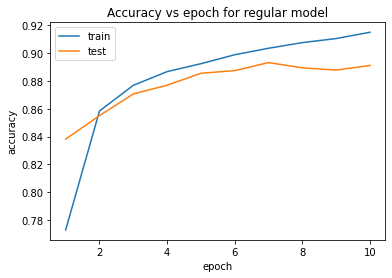

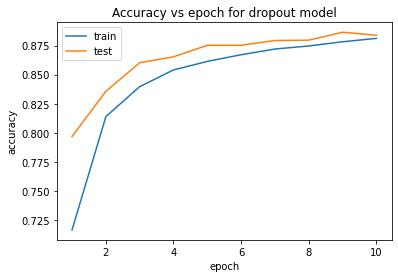

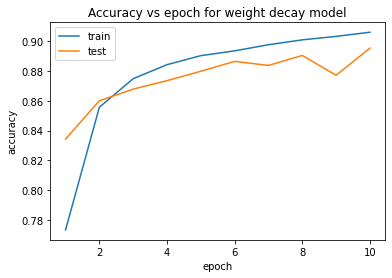

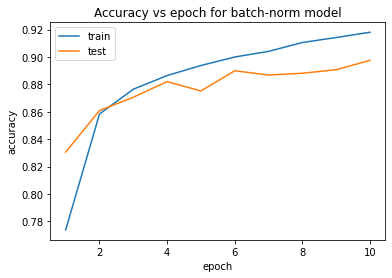

In [22]:
#plot accuracy from json files
with open('Regular_Model.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_regular_model = plt.figure()
plt.plot(range(1, len(results_dict['train_acc']) + 1),
             results_dict['train_acc'])
plt.plot(range(1, len(results_dict['test_acc']) + 1),
             results_dict['test_acc'])
plt.legend(['train','test'])
plt.title('Accuracy vs epoch for regular model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
accuracies_regular_model.savefig('Regular_model_accuracies_plot.png')
plt.show()

with open('Dropout_Model.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_dropout_model = plt.figure()
plt.plot(range(1, len(results_dict['train_acc']) + 1),
             results_dict['train_acc'])
plt.plot(range(1, len(results_dict['test_acc']) + 1),
             results_dict['test_acc'])
plt.legend(['train','test'])
plt.title('Accuracy vs epoch for dropout model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
accuracies_dropout_model.savefig('Dropout_model_accuracies_plot.png')
plt.show()

with open('Weight_Decay_Model.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_wd_model = plt.figure()
plt.plot(range(1, len(results_dict['train_acc']) + 1),
             results_dict['train_acc'])
plt.plot(range(1, len(results_dict['test_acc']) + 1),
             results_dict['test_acc'])
plt.legend(['train','test'])
plt.title('Accuracy vs epoch for weight decay model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
accuracies_wd_model.savefig('Weight_Decay_Model_accuracies_plot.png')
plt.show()

with open('BN_Model.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_bn_model = plt.figure()
plt.plot(range(1, len(results_dict['train_acc']) + 1),
             results_dict['train_acc'])
plt.plot(range(1, len(results_dict['test_acc']) + 1),
             results_dict['test_acc'])
plt.legend(['train','test'])
plt.title('Accuracy vs epoch for batch-norm model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
accuracies_bn_model.savefig('Batch_Norm_Model_accuracies_plot.png')
plt.show()